In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import datetime
import re

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
data_folder = './MovieSummaries/'

summaries = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])

In [76]:
# mergin databases
summaries = summaries.merge(movie_meta, on="wiki_id", how = 'right')
summaries["languages"] = summaries.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
summaries["coutries"] = summaries.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
summaries["genres"] = summaries.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [91]:
# import dataset scraped from wikipedia

df_wikipedia = pd.read_json('with_plot.txt', lines=True)
df_wikipedia = df_wikipedia[['id', 'directors', 'plot']]
df_wikipedia.rename(columns={'id':'wiki_id', 'plot':'summary'}, inplace=True)
df_wikipedia = df_wikipedia[df_wikipedia['summary'].notna()] # only keep rows that have a plot summary

In [77]:
summaries.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
0,975900,"Set in the second half of the 22nd century, th...",/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,NaN,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,NaN,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,A series of murders of rich young women throug...,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,"Eva, an upper class housewife, becomes frustra...",/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [78]:
len(summaries)

81741

In [99]:
summaries.loc[summaries['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(summaries['release_date'])
summaries['release_date'] = dates

In [100]:
# df is used for average sentiment analysis over movies
df = summaries.copy()

In [101]:
df = df.sort_values(by=['release_date'])

In [102]:
df = df.dropna(subset=['summary'])

In [103]:
df.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
25563,73372,The scene is all filmed from a stationary came...,/m/0jq3g,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67253,10109752,After finding out that her father is suffering...,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
81230,10104497,James J. Corbett and Peter Courtney both take ...,/m/02q1zd3,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67567,10330688,The film consists of a series of animations on...,/m/02q8pr6,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Short Film, Silent film, Animation, Comedy, I..."
73179,10483292,Two men stand working as blacksmiths. The one ...,/m/02qfh7r,Les Forgerons,1895-01-01,NaN,0.816667,[Silent film],[France],"[Short Film, Silent film, Indie, Black-and-whi..."


In [104]:
len(df)

42204

Here we have that df contains all the movies with their informations, ordered by release date with a existing summary. We will use this to derive all our other dataframes (per countries, per date). We have 42204 movies compared to 81741 before.

## Creation of a dataset with plot summmaries 

In [105]:
df_additional = summaries.copy()
df_additional = df_additional[df_additional['release_date'].notna()]  

In [194]:
# Method for a first cleanup of the data ; this will need more work in the future

def remove_html(line):
    CLEANR = re.compile('<!--.*--') 
    CLEANR2 = re.compile('<ref.*</ref')  
    CLEANR3 = re.compile('<Ref.*</ref')
    CLEANR4 = re.compile('<ref.*/>')
    x = re.sub(CLEANR, '', line)
    x = re.sub(CLEANR3, '', x)
    x = re.sub(CLEANR2, '', x)
    x = re.sub(CLEANR4, '', x)
    x = x.replace('\n', '') # remove newlines
    x = x.replace('([[', '') 
    x = x.replace(']])', '') 
    x = x.replace('[[', '') 
    x = x.replace(']]', '')
    x = x.replace('|', ' | ')
    x = x.replace('**', '"') 
    x = x.replace('*', "'") 
    if(len(line) < 50):
        x = ""      
    return x

# remove html references in plot summaries
df_wikipedia['summary'] = df_wikipedia['summary'].apply(lambda x : remove_html(x))



In [ ]:
rows = df_wikipedia.sample(10)
for index, row in rows.iterrows():
    print(row['summary'])
    print("===================")

In [196]:
# Method that takes the wikipedia summary if the CMU database doesn't provide one

def pick_better_plot(x):
    if x.summary_x == '':
        if x['summary_y'] == '':
            return np.nan
        else:
            return x['summary_y']
    else:
        return x['summary_x']

# since we base our analysis on release dates, we remove films with no release date
df_additional = df_additional[df_additional['release_date'].notna()]  
    
summary_df = pd.merge(df_additional,df_wikipedia,on='wiki_id',how='left')
summary_df['summary_x'] = summary_df['summary_x'].fillna('')
summary_df['summary_y'] = summary_df['summary_y'].fillna('')


# create new column with the wikipedia summary if CMU doesn't provide one
summary_df['summary'] = summary_df.apply(lambda x : pick_better_plot(x),axis=1)

# keep only rows that have a summary
summary_df = summary_df[summary_df['summary'].notna()]
summary_df = summary_df.drop(columns=['summary_x', 'summary_y'])

In [197]:
analyzer = SentimentIntensityAnalyzer()

In [198]:
def get_country_movies(df, country):
    return df[df.coutries.apply(lambda x : country in x)]

In [199]:
def create_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year < end) & (df.release_date.dt.year > begin)]

In [200]:
def plot_sentiment_country_span(span, attribute, year:bool):
    fig, axs = plt.subplots(figsize=(25, 5))
    if year:
        sentiments = span.groupby(span.release_date.dt.year)[attribute].mean()
    else:
        sentiments = span.groupby(span.release_date)[attribute].mean()
    sentiments.plot(kind='bar', rot=90, ax=axs)

In [201]:
def sentiment_df(df):
    
    df_copy = df.copy()
    
    # calculate the sentiment over the summaries
    df_copy['sentiment'] = df_copy['summary'].apply(lambda x: analyzer.polarity_scores(x))

    # isolate the most interesting values
    df_copy['positive'] = df_copy['sentiment'].apply(lambda x: x['pos'])
    df_copy['neutral'] = df_copy['sentiment'].apply(lambda x: x['neu'])
    df_copy['negative'] = df_copy['sentiment'].apply(lambda x: x['neg'])
    df_copy['compound'] = df_copy['sentiment'].apply(lambda x: x['compound'])
    
    return df_copy

In [202]:
# the texts are in english
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

Firstly we'll just look at movies made around the WW2, that is from 1930 to 1955.

In [237]:
begin = 1930
end = 1955

In [238]:
df_ww2 = create_history_span(summary_df, begin, end)
print("There is", len(df_ww2), "movies made worldwide bewteen", begin, "and", end)

There is 8231 movies made worldwide bewteen 1930 and 1955


We will first run a sentiment analysis over all **german** movie during this period **(1930 to 1955)**.

In [239]:
# get all the german movies
df_ww2_germany = get_country_movies(df_ww2, 'Germany')

# calculate sentiment and add it nicely to the df
df_ww2_germany = sentiment_df(df_ww2_germany)

In [240]:
print("There is", len(df_ww2_germany), "movies made in Germany bewteen", begin, "and", end)

There is 110 movies made in Germany bewteen 1930 and 1955


In [303]:
# get most common words across all summaries by summing up the summaries
def most_common_in_text(text):
    summary = nlp(text)
    tokens = [token.lemma_ for token in summary if token.is_stop != True and token.is_punct != True]
    tokens_lower = [x.lower() for x in tokens]
    return Counter(tokens_lower)

# from tutorial 10
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    

def most_common_sum(df, n):
    text = ' '.join(df["summary"])
    if(len(text) < 1000000):
        return most_common_in_text(text).most_common(n)
    else:
        chunks = [x for x in get_chunks(text,1000000)]
        master_list = []
        for chunk in chunks:
            counter = most_common_in_text(chunk).items()
            [master_list.append(x) for x in counter]
        d = {x: 0 for x, _ in master_list}
        for word, num in master_list:
            d[word] += num
        out = list(map(tuple, d.items()))
        sorted_list = sorted(out,key=lambda t: t[1],reverse=True)
        return sorted_list[0:n]
            
            
            
        
    

In [287]:
print(most_common_sum(df_ww2_germany, 40))

[('film', 73), ('german', 62), ('find', 53), ('war', 50), ('man', 49), ('love', 49), (' ', 46), ('von', 46), ('leave', 45), ('young', 41), ('take', 40), ('father', 40), ('fall', 37), ('return', 37), ('meet', 35), ('woman', 33), ('|', 32), ('order', 31), ('british', 31), ('girl', 31), ('tell', 31), ('manuela', 31), ('world', 30), ('escape', 29), ('nazi', 29), ('die', 29), ('day', 29), ('play', 28), ('work', 28), ('hitler', 27), ('end', 27), ('son', 27), ('plan', 27), ('try', 26), ('baron', 26), ('wife', 25), ('follow', 25), ('give', 25), ('old', 25), ('family', 25)]


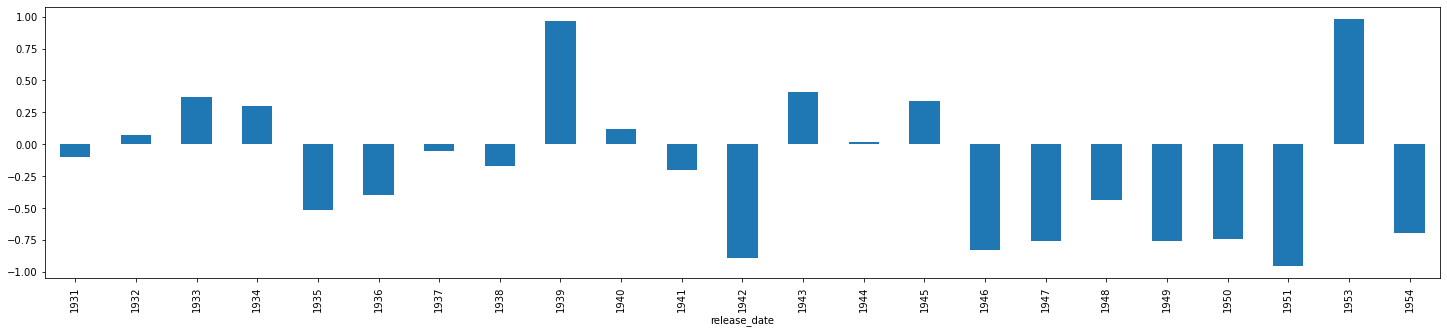

In [113]:
plot_sentiment_country_span(df_ww2_germany, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1946-1951) overall sentiment is negative.

---

We then run a sentiment analysis over all **french** movie during this period **(1930 to 1955)**.

In [192]:
# get all the french movies
df_ww2_french = get_country_movies(df_ww2, 'France')

# calculate sentiment and add it nicely to the df
df_ww2_french = sentiment_df(df_ww2_french)

In [193]:
print("There is", len(df_ww2_french), "movies made in France bewteen", begin, "and", end)

There is 193 movies made in France bewteen 1930 and 1955


In [273]:
print(most_common_sum(df_ww2_french, 40))

[('find', 138), (' ', 129), ('love', 125), ('man', 109), ('leave', 96), ('tell', 91), ('take', 91), ('young', 82), ('return', 82), ('woman', 81), ('film', 81), ('life', 69), ('go', 69), ('try', 68), ('away', 63), ('wife', 62), ('father', 62), ('war', 60), ('paris', 58), ('end', 57), ('night', 56), ('come', 56), ('kill', 55), ('town', 55), ('day', 55), ('friend', 55), ('old', 53), ('robert', 53), ('french', 52), ('de', 50), ('fall', 49), ('police', 49), ('see', 47), ('run', 46), ('time', 45), ('work', 45), ('decide', 45), ('jean', 44), ('arrive', 44), ('order', 43)]


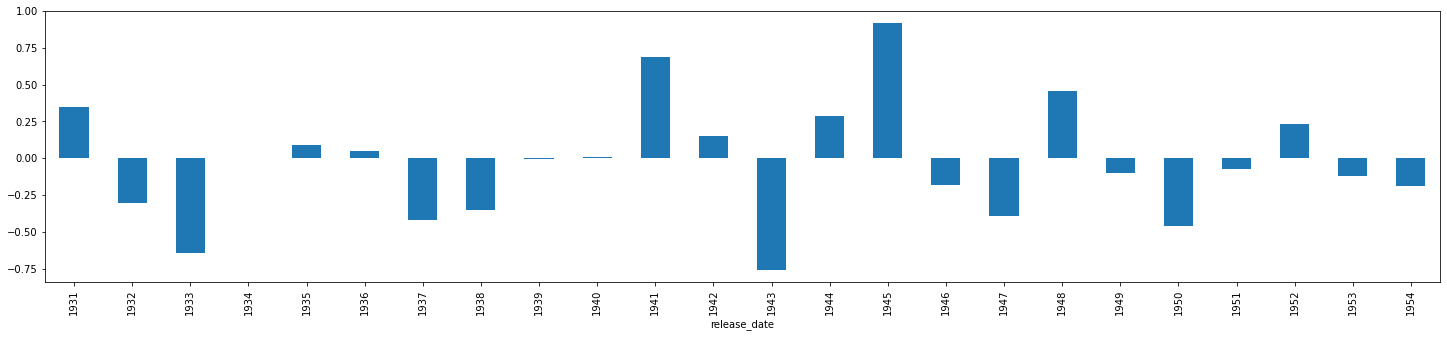

In [116]:
plot_sentiment_country_span(df_ww2_french, 'compound', year=True)

We can't see any form of pattern here ?... Except the 1945 year that is very positive (victory for France)

---

We then run a sentiment analysis over all **italy** movie during this period **(1930 to 1955)**.

In [117]:
# get all the french movies
df_ww2_italy = get_country_movies(df_ww2, 'Italy')

# calculate sentiment and add it nicely to the df
df_ww2_italy = sentiment_df(df_ww2_italy)

In [118]:
print("There is", len(df_ww2_italy), "movies made in Italy bewteen", begin, "and", end)

There is 251 movies made in Italy bewteen 1930 and 1955


In [274]:
print(most_common_sum(df_ww2_italy, 40))

[('young', 127), ('find', 122), ('love', 117), (' ', 111), ('man', 105), ('take', 92), ('leave', 90), ('return', 83), ('film', 82), ('go', 81), ('woman', 78), ('try', 78), ('son', 77), ('girl', 75), ('family', 71), ('wife', 70), ('kill', 69), ('life', 69), ('end', 68), ('tell', 68), ('war', 67), ('money', 66), ('friend', 65), ('antonio', 65), ('home', 63), ('time', 62), ('daughter', 62), ('fall', 62), ('meet', 61), ('day', 61), ('work', 59), ('marry', 59), ('live', 57), ('decide', 57), ('father', 57), ('house', 57), ('away', 57), ('police', 56), ('town', 55), ('help', 55)]


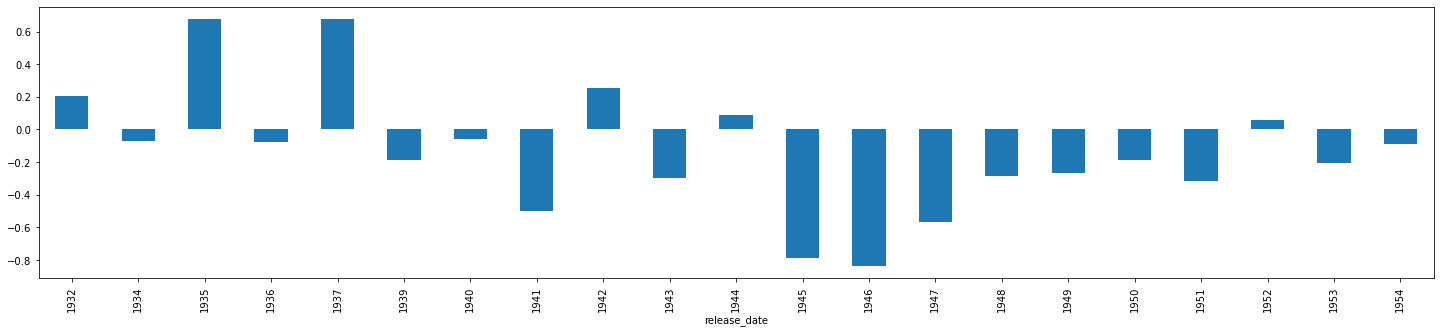

In [119]:
plot_sentiment_country_span(df_ww2_italy, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1945-1949) overall sentiment is negative.

---

We then run a sentiment analysis over all **united kingdom** movie during this period **(1930 to 1955)**.

In [120]:
# get all the UK movies
df_ww2_UK = get_country_movies(df_ww2, 'United Kingdom')

# calculate sentiment and add it nicely to the df
df_ww2_UK = sentiment_df(df_ww2_UK)

In [121]:
print("There is", len(df_ww2_UK), "movies made in UK bewteen", begin, "and", end)

There is 1095 movies made in UK bewteen 1930 and 1955


In [302]:
print(most_common_sum(df_ww2_UK, 40))

('inspector', 57)
[(' ', 893), ('find', 627), ('man', 546), ('leave', 471), ('take', 447), ('love', 416), ('tell', 415), ('return', 370), ('try', 356), ('go', 347), ('film', 340), ('work', 325), ('young', 309), ('wife', 305), ('war', 295), ('come', 294), ('fall', 292), ('london', 289), ('police', 279), ('home', 274), ('woman', 270), ('marry', 270), ('british', 269), ('father', 264), ('arrive', 262), ('time', 262), ('kill', 259), ('meet', 259), ('life', 250), ('new', 248), ('train', 245), ('friend', 242), ('run', 238), ('house', 237), ('help', 237), ('murder', 232), ('day', 231), ('away', 230), ('discover', 229), ('year', 227)]


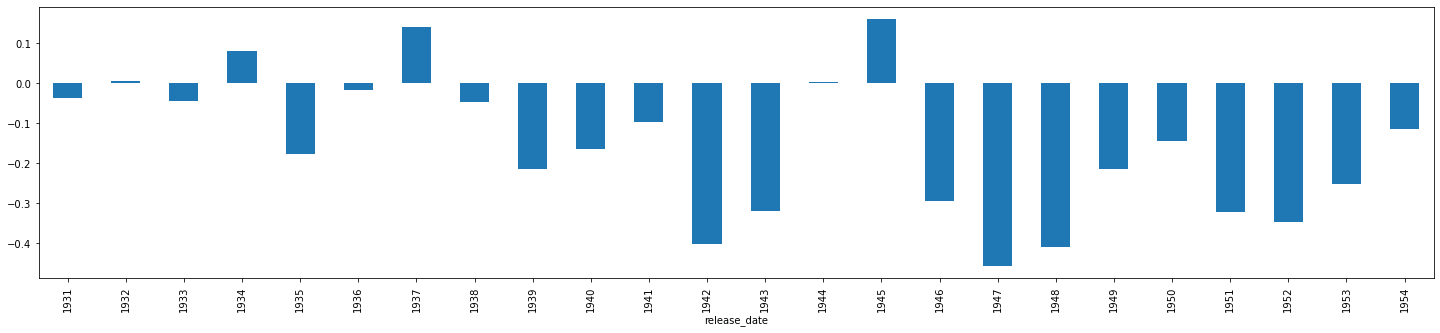

In [122]:
plot_sentiment_country_span(df_ww2_UK, 'compound', year=True)

Seeing the compound value of all the movies at this period we can see that the war (1939-1945) overall sentiment is negative, execpt the last year (vicory for UK) where it is positive. 
Also the post war period is tainted with negativity  (1946 - 1951)

---

We then run a sentiment analysis over all **soviet union** movie during this period **(1930 to 1955)**.

In [304]:
# get all the Russian movies
df_ww2_SovietUnion = get_country_movies(df_ww2, 'Soviet Union')

# calculate sentiment and add it nicely to the df
df_ww2_SovietUnion = sentiment_df(df_ww2_SovietUnion)

In [305]:
print("There is", len(df_ww2_SovietUnion), "movies made in Soviet Union bewteen", begin, "and", end)

There is 54 movies made in Soviet Union bewteen 1930 and 1955


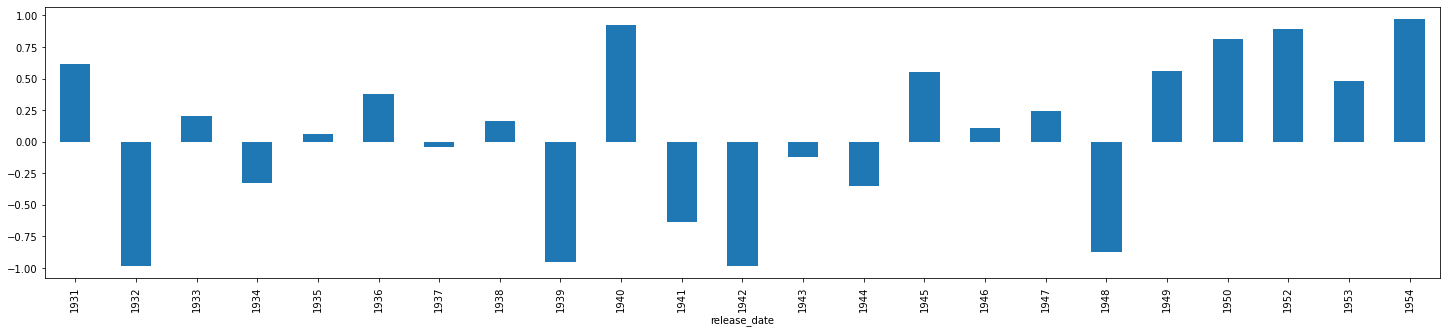

In [306]:
plot_sentiment_country_span(df_ww2_SovietUnion, 'compound', year=True)

We then run a sentiment analysis over all **USA** movie during this period **(1930 to 1955)**.

In [307]:
# get all the USA movies
df_ww2_USA = get_country_movies(df_ww2, 'United States of America')

# calculate sentiment and add it nicely to the df
df_ww2_USA = sentiment_df(df_ww2_USA)

In [308]:
print("There is", len(df_ww2_USA), "movies made in USA bewteen", begin, "and", end)

There is 5591 movies made in USA bewteen 1930 and 1955


In [309]:
print(most_common_sum(df_ww2_USA, 40))

[(' ', 7473), ('find', 4117), ('man', 4009), ('tell', 3594), ('leave', 3433), ('try', 3053), ('take', 2761), ('go', 2658), ('love', 2585), ('new', 2557), ('return', 2544), ('kill', 2402), ('come', 2208), ('tom', 2064), ('|', 1981), ('father', 1950), ('time', 1945), ('work', 1890), ('home', 1879), ('friend', 1860), ('marry', 1825), ('get', 1818), ('run', 1807), ('fall', 1805), ('meet', 1779), ('see', 1771), ('help', 1767), ('away', 1687), ('decide', 1670), ('money', 1659), ('arrive', 1647), ('end', 1639), ('give', 1623), ('turn', 1615), ('woman', 1600), ('day', 1588), ('life', 1586), ('later', 1559), ('want', 1556), ('police', 1553)]


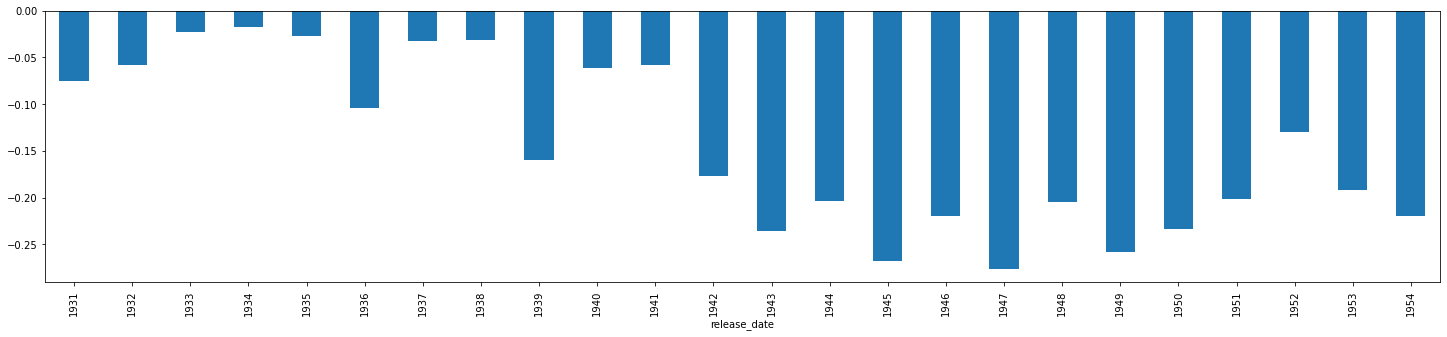

In [128]:
plot_sentiment_country_span(df_ww2_USA, 'compound', year=True)

Seeing the compound value of all the movies at this period we can see that the war and prewar (1941-1951) overall sentiment is very negative. There is a clear mark between before the involvement of USA in the war and after.

---

We then run a sentiment analysis over all **Japan** movie during this period **(1930 to 1955)**.

In [310]:
# get all the Japan movies
df_ww2_japan = get_country_movies(df_ww2, 'Japan')

# calculate sentiment and add it nicely to the df
df_ww2_japan = sentiment_df(df_ww2_japan)

In [311]:
print("There is", len(df_ww2_japan), "movies made in Japan bewteen", begin, "and", end)

There is 74 movies made in Japan bewteen 1930 and 1955


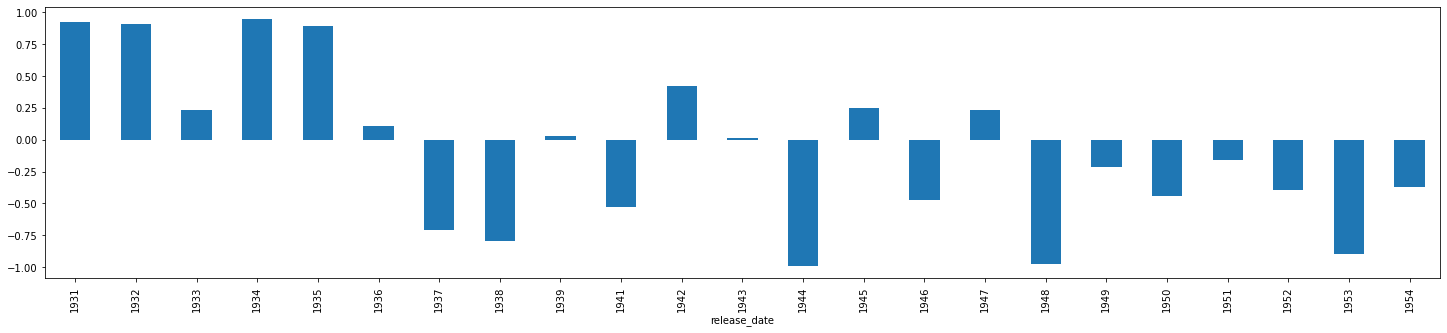

In [312]:
plot_sentiment_country_span(df_ww2_japan, 'compound', year=True)

Pre war (before 1939)  is pretty positive. The rest of the period is moslty negative.